## DS_GA 1001 Final Project(Hengyu Code)
-----
#### Focus on 
1. Data cleaning
2. mainly visualization of feature distribution
3. Feature selection: greedy search, recursive feature elimination, model feature ranking
4. Binary classification: Gradient Boosting, AdaBoost, XGBoost, Decision Trees, Random Forest
5. Multi-class classification

In [174]:
import xgboost
import metrics 
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [596]:
datadir = os.getcwd()
orig_data = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv', header = 0)
orig_data.head()#Can use some information about the url to get the data


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [181]:
orig_data.shape

(39644, 61)

In [597]:
url_data = orig_data['url']
year_data = [url_data[i].split('/')[3] for i in range(len(url_data))]
month_data = [url_data[i].split('/')[4] for i in range(len(url_data))]
date_data = [url_data[i].split('/')[4] + " " +url_data[i].split('/')[5] for i in range(len(url_data))]
published_date = [time.strptime(year_data[i] + " "+ date_data[i], '%Y %m %d') for i in range(len(url_data))]
orig_data[' year'] = year_data
orig_data[' month'] = month_data
orig_data[' date'] = published_date
orig_data.drop('url',1, inplace = True)

In [598]:
len(orig_data)

39644

In [601]:
orig_data[' n_tokens_content'].describe()

count    39644.000000
mean       546.514731
std        471.107508
min          0.000000
25%        246.000000
50%        409.000000
75%        716.000000
max       8474.000000
Name:  n_tokens_content, dtype: float64

In [607]:
len(orig_data[orig_data[' num_videos'] > 50])

30

In [5]:
cleaned_data = orig_data[orig_data[' n_tokens_content'] != 0]
cleaned_data = cleaned_data[cleaned_data[' n_unique_tokens'] <= 1]
cleaned_data = cleaned_data[cleaned_data[' num_hrefs'] <= 100]
cleaned_data = cleaned_data[cleaned_data[' num_videos'] <= 50]


### Time visualization
I will plot the graph respectively on year, month, date and weekdays.


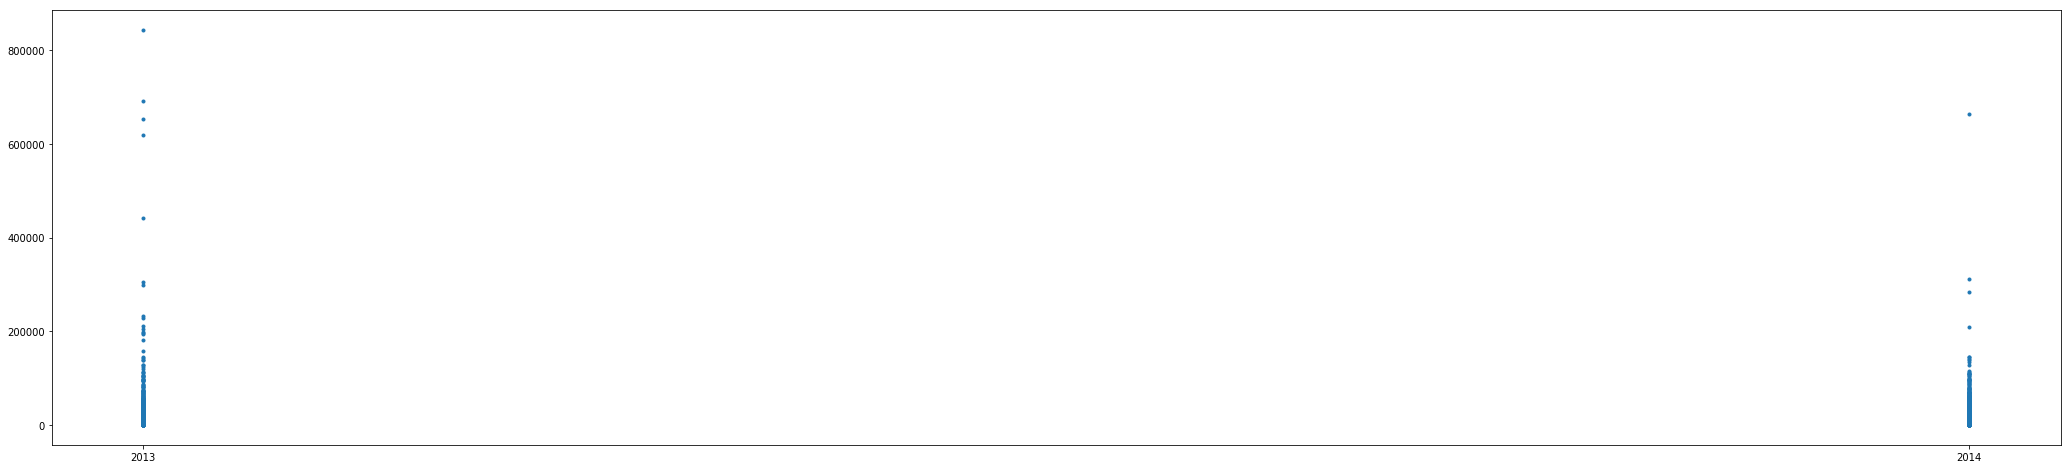

In [7]:
#year_data visualization
year_data = cleaned_data[[' year', ' shares']]

fig,ax = plt.subplots(figsize = (36,8))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
plt.plot(year_data[' year'], year_data[' shares'], '.')
#It is apparent that there is a tendency for higher clicks for reports on 2013. However it is reasonable as earlier
#posts will have a higher click rates

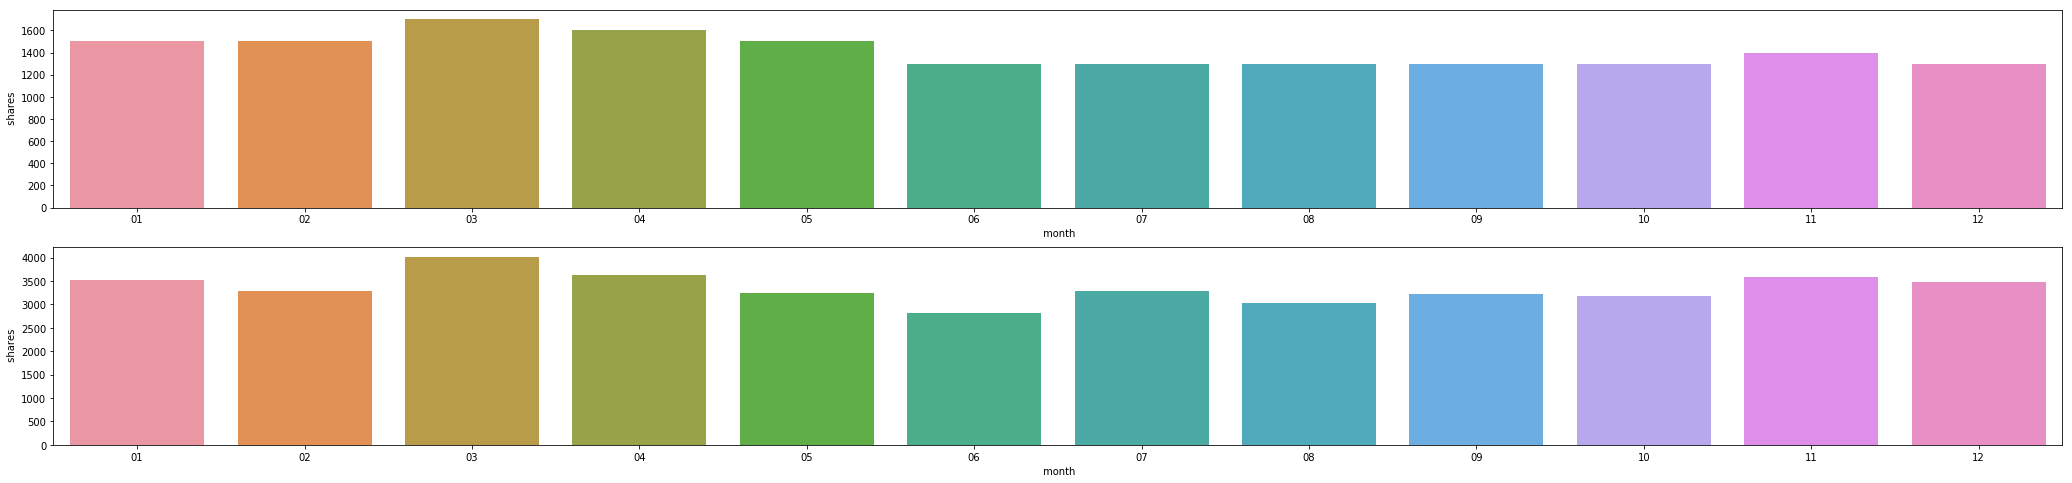

In [8]:
#month_data visualization
month_data = cleaned_data[[' month', ' shares']]
month_median = month_data.groupby(' month').median()
month_mean = month_data.groupby(' month').mean()
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (36,8))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= month_median.index, y = month_median[' shares'], ax=ax[0])
sns.barplot(x = month_mean.index, y = month_mean[' shares'], ax = ax[1])
#The bar plot showing both the mean and median for shares of different months all presents similar trneds, 
#where it is rather interesting that the shares to peak during March.


### Further observe the popularity of different categories

In [572]:
cleaned_data.columns
#Does exists articles whose n_tokens_content is 0

Index([' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_p

In [573]:
life_data = cleaned_data[cleaned_data[' data_channel_is_lifestyle'] == 1]
ent_data = cleaned_data[cleaned_data[' data_channel_is_entertainment'] == 1]
bus_data = cleaned_data[cleaned_data[' data_channel_is_bus'] == 1]
socmed_data = cleaned_data[cleaned_data[' data_channel_is_socmed'] == 1]
tech_data = cleaned_data[cleaned_data[' data_channel_is_tech'] == 1]
world_data = cleaned_data[cleaned_data[' data_channel_is_world'] == 1]

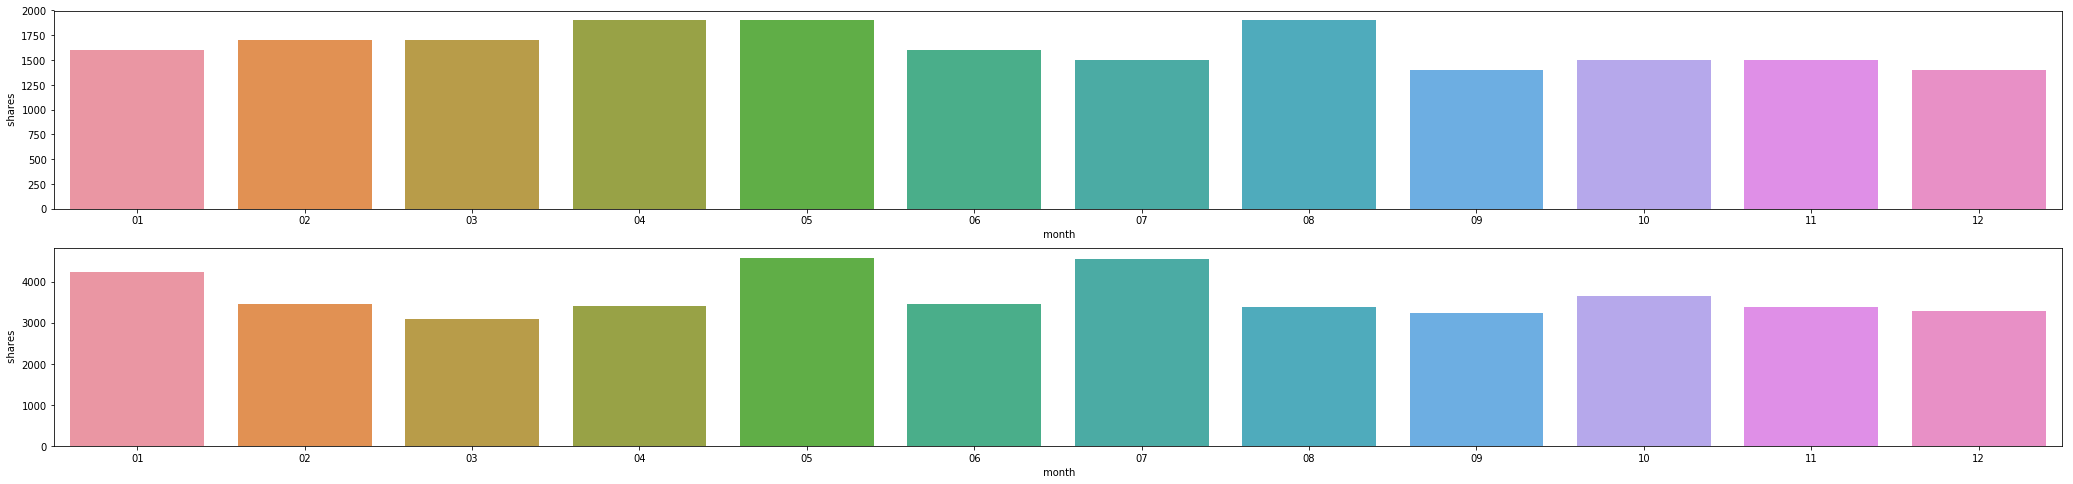

In [10]:
#month_data visualization for life_data
month_data = life_data[[' month', ' shares']]
month_median = month_data.groupby(' month').median()
month_mean = month_data.groupby(' month').mean()
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (36,8))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= month_median.index, y = month_median[' shares'], ax=ax[0])
sns.barplot(x = month_mean.index, y = month_mean[' shares'], ax = ax[1])
#The bar plot showing both the mean and median for shares of different months all presents similar trneds, 
#where it is rather interesting that the shares to peak during March.


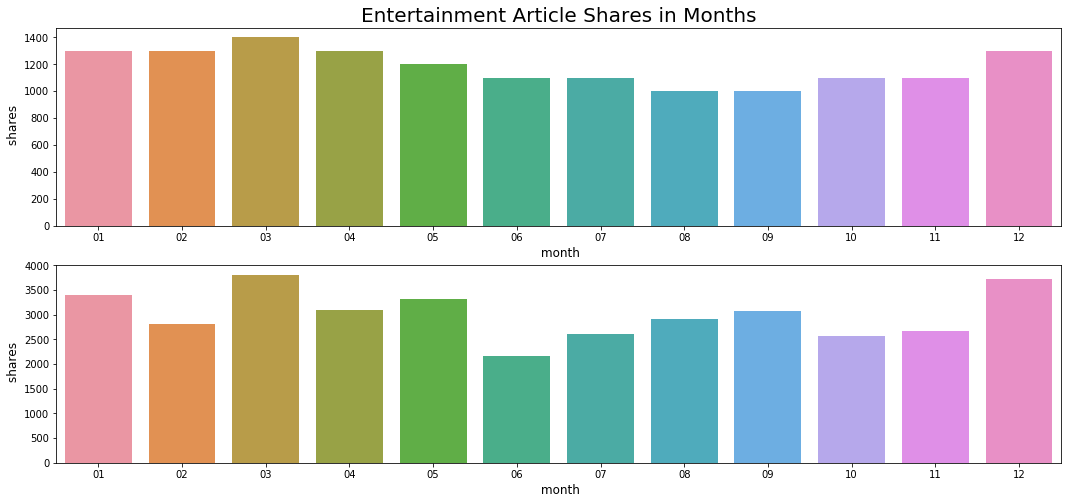

In [595]:
#month_data visualization for ent_data
month_data = ent_data[[' month', ' shares']]
month_median = month_data.groupby(' month').median()
month_mean = month_data.groupby(' month').mean()
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (18,8))
ax[0].set_xlabel('Month',fontsize = 12)
ax[1].set_xlabel('Month',fontsize = 12)
ax[1].set_ylabel('Mean Shares',fontsize = 12)
ax[0].set_ylabel('Median Shares',fontsize = 12)
ax[0].set_title('Entertainment Article Shares in Months',fontsize = 20)
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= month_median.index, y = month_median[' shares'], ax=ax[0])
sns.barplot(x = month_mean.index, y = month_mean[' shares'], ax = ax[1])
plt.savefig('ent_data.png')
#The bar plot showing both the mean and median for shares of different months all presents similar trneds, 
#where it is rather interesting that the shares to peak during March.


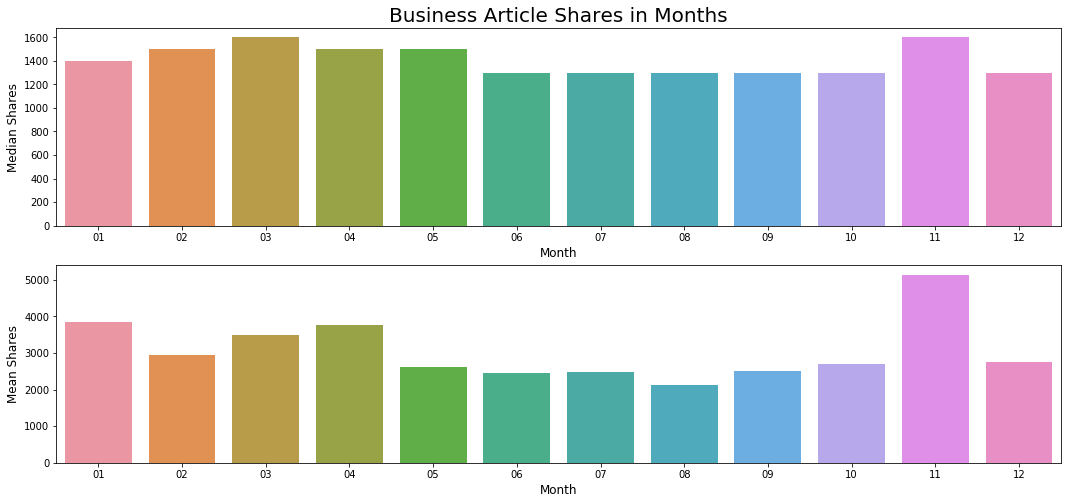

In [593]:
#month_data visualization for bus_data
month_data = bus_data[[' month', ' shares']]
month_median = month_data.groupby(' month').median()
month_mean = month_data.groupby(' month').mean()
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (18,8))
ax[0].set_xlabel('Month',fontsize = 12)
ax[1].set_xlabel('Month',fontsize = 12)
ax[1].set_ylabel('Mean Shares',fontsize = 12)
ax[0].set_ylabel('Median Shares',fontsize = 12)
ax[0].set_title('Business Article Shares in Months',fontsize = 20)
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= month_median.index.values, y = month_median[' shares'].values, ax=ax[0])
sns.barplot(x = month_mean.index.values, y = month_mean[' shares'].values, ax = ax[1])
#The bar plot showing both the mean and median for shares of different months all presents similar trneds, 
#where it is rather interesting that the shares to peak during March.
plt.savefig('bus_data.png')

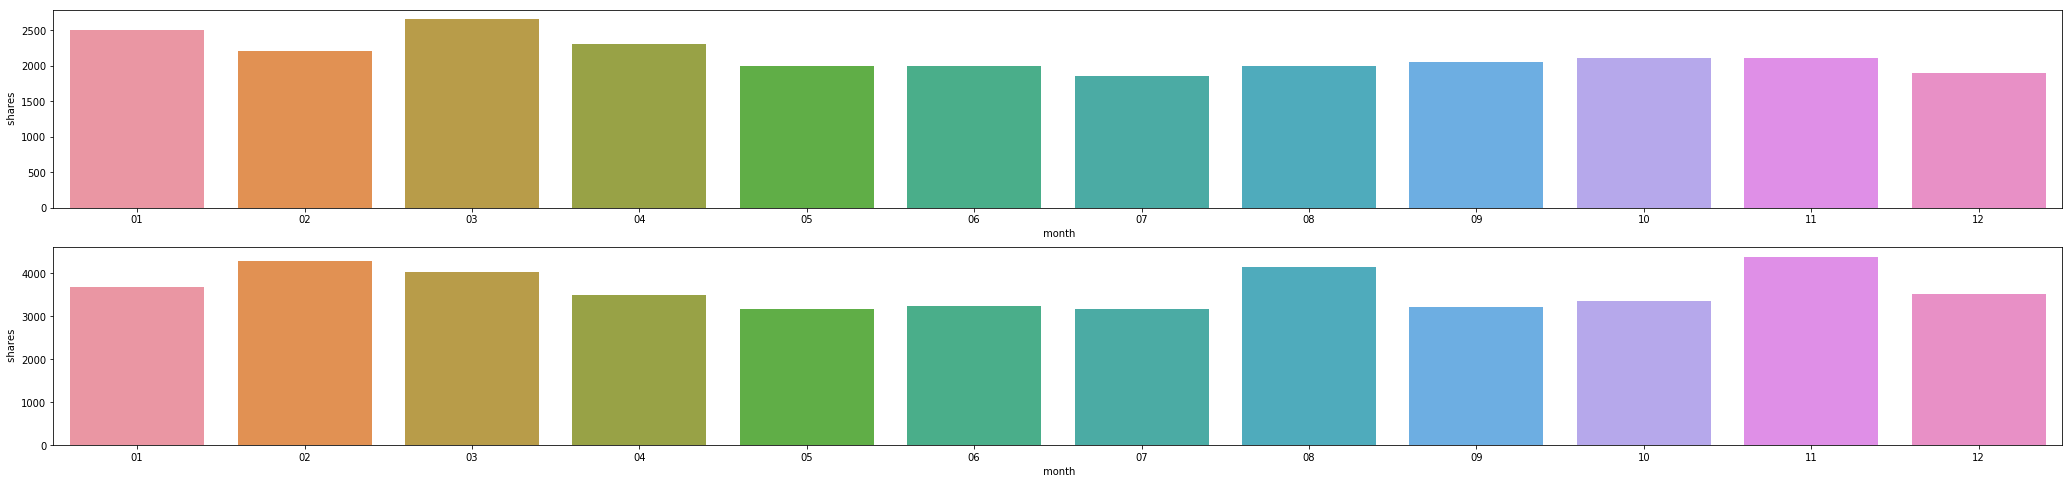

In [579]:
#month_data visualization for socmed_data
month_data = socmed_data[[' month', ' shares']]
month_median = month_data.groupby(' month').median()
month_mean = month_data.groupby(' month').mean()
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (36,8))
plt.xlabel('Month')
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= month_median.index, y = month_median[' shares'], ax=ax[0])
sns.barplot(x = month_mean.index, y = month_mean[' shares'], ax = ax[1])
#The bar plot showing both the mean and median for shares of different months all presents similar trneds, 
#where it is rather interesting that the shares to peak during March.


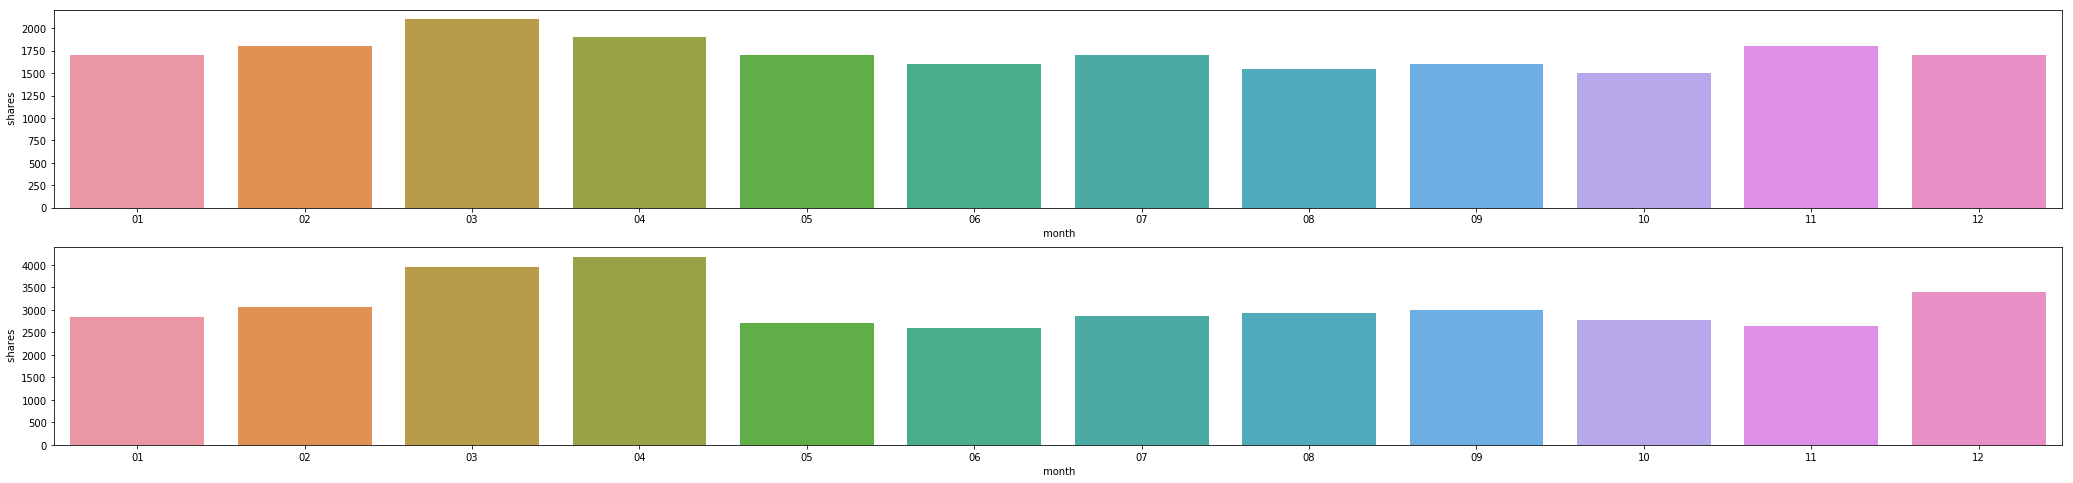

In [14]:
#month_data visualization for tech_data
month_data = tech_data[[' month', ' shares']]
month_median = month_data.groupby(' month').median()
month_mean = month_data.groupby(' month').mean()
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (36,8))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= month_median.index, y = month_median[' shares'], ax=ax[0])
sns.barplot(x = month_mean.index, y = month_mean[' shares'], ax = ax[1])
#The bar plot showing both the mean and median for shares of different months all presents similar trneds, 
#where it is rather interesting that the shares to peak during March.


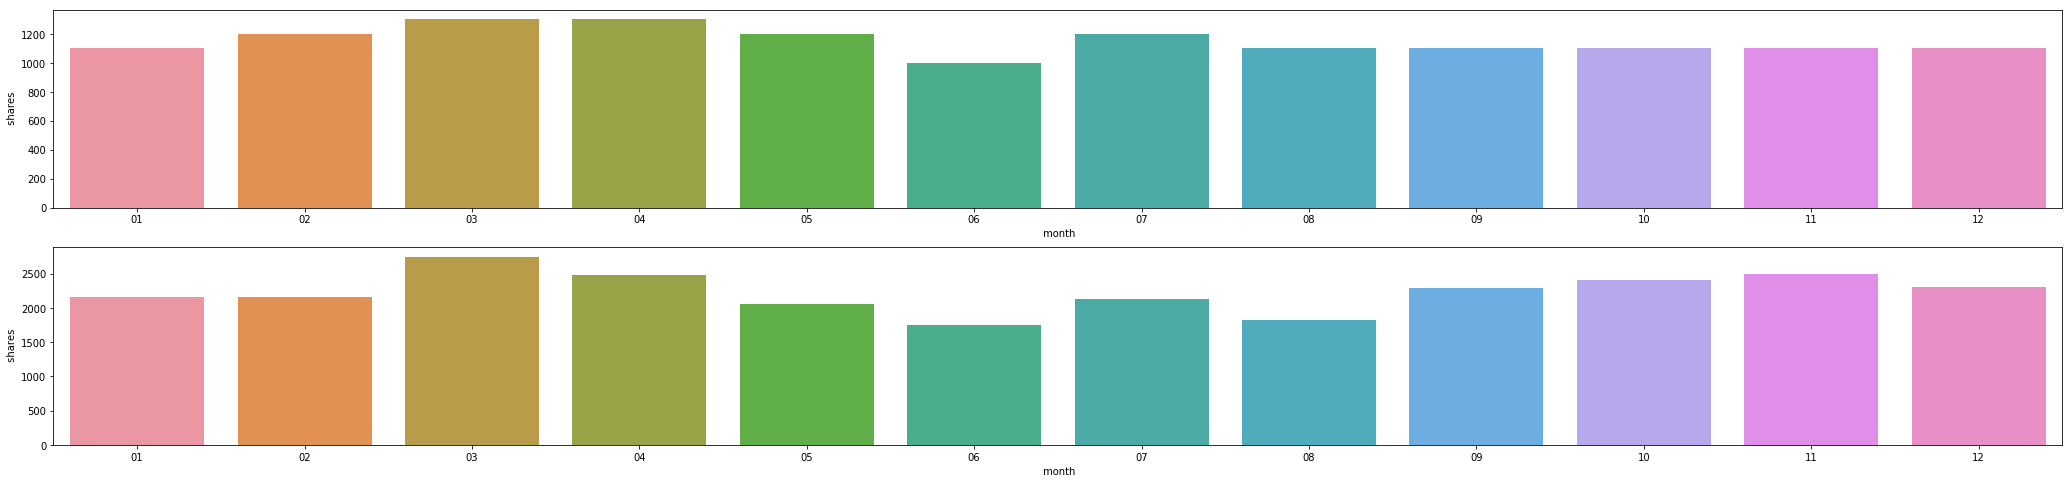

In [15]:
#month_data visualization for world_data
month_data = world_data[[' month', ' shares']]
month_median = month_data.groupby(' month').median()
month_mean = month_data.groupby(' month').mean()
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (36,8))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= month_median.index, y = month_median[' shares'], ax=ax[0])
sns.barplot(x = month_mean.index, y = month_mean[' shares'], ax = ax[1])
#The bar plot showing both the mean and median for shares of different months all presents similar trneds, 
#where it is rather interesting that the shares to peak during March.


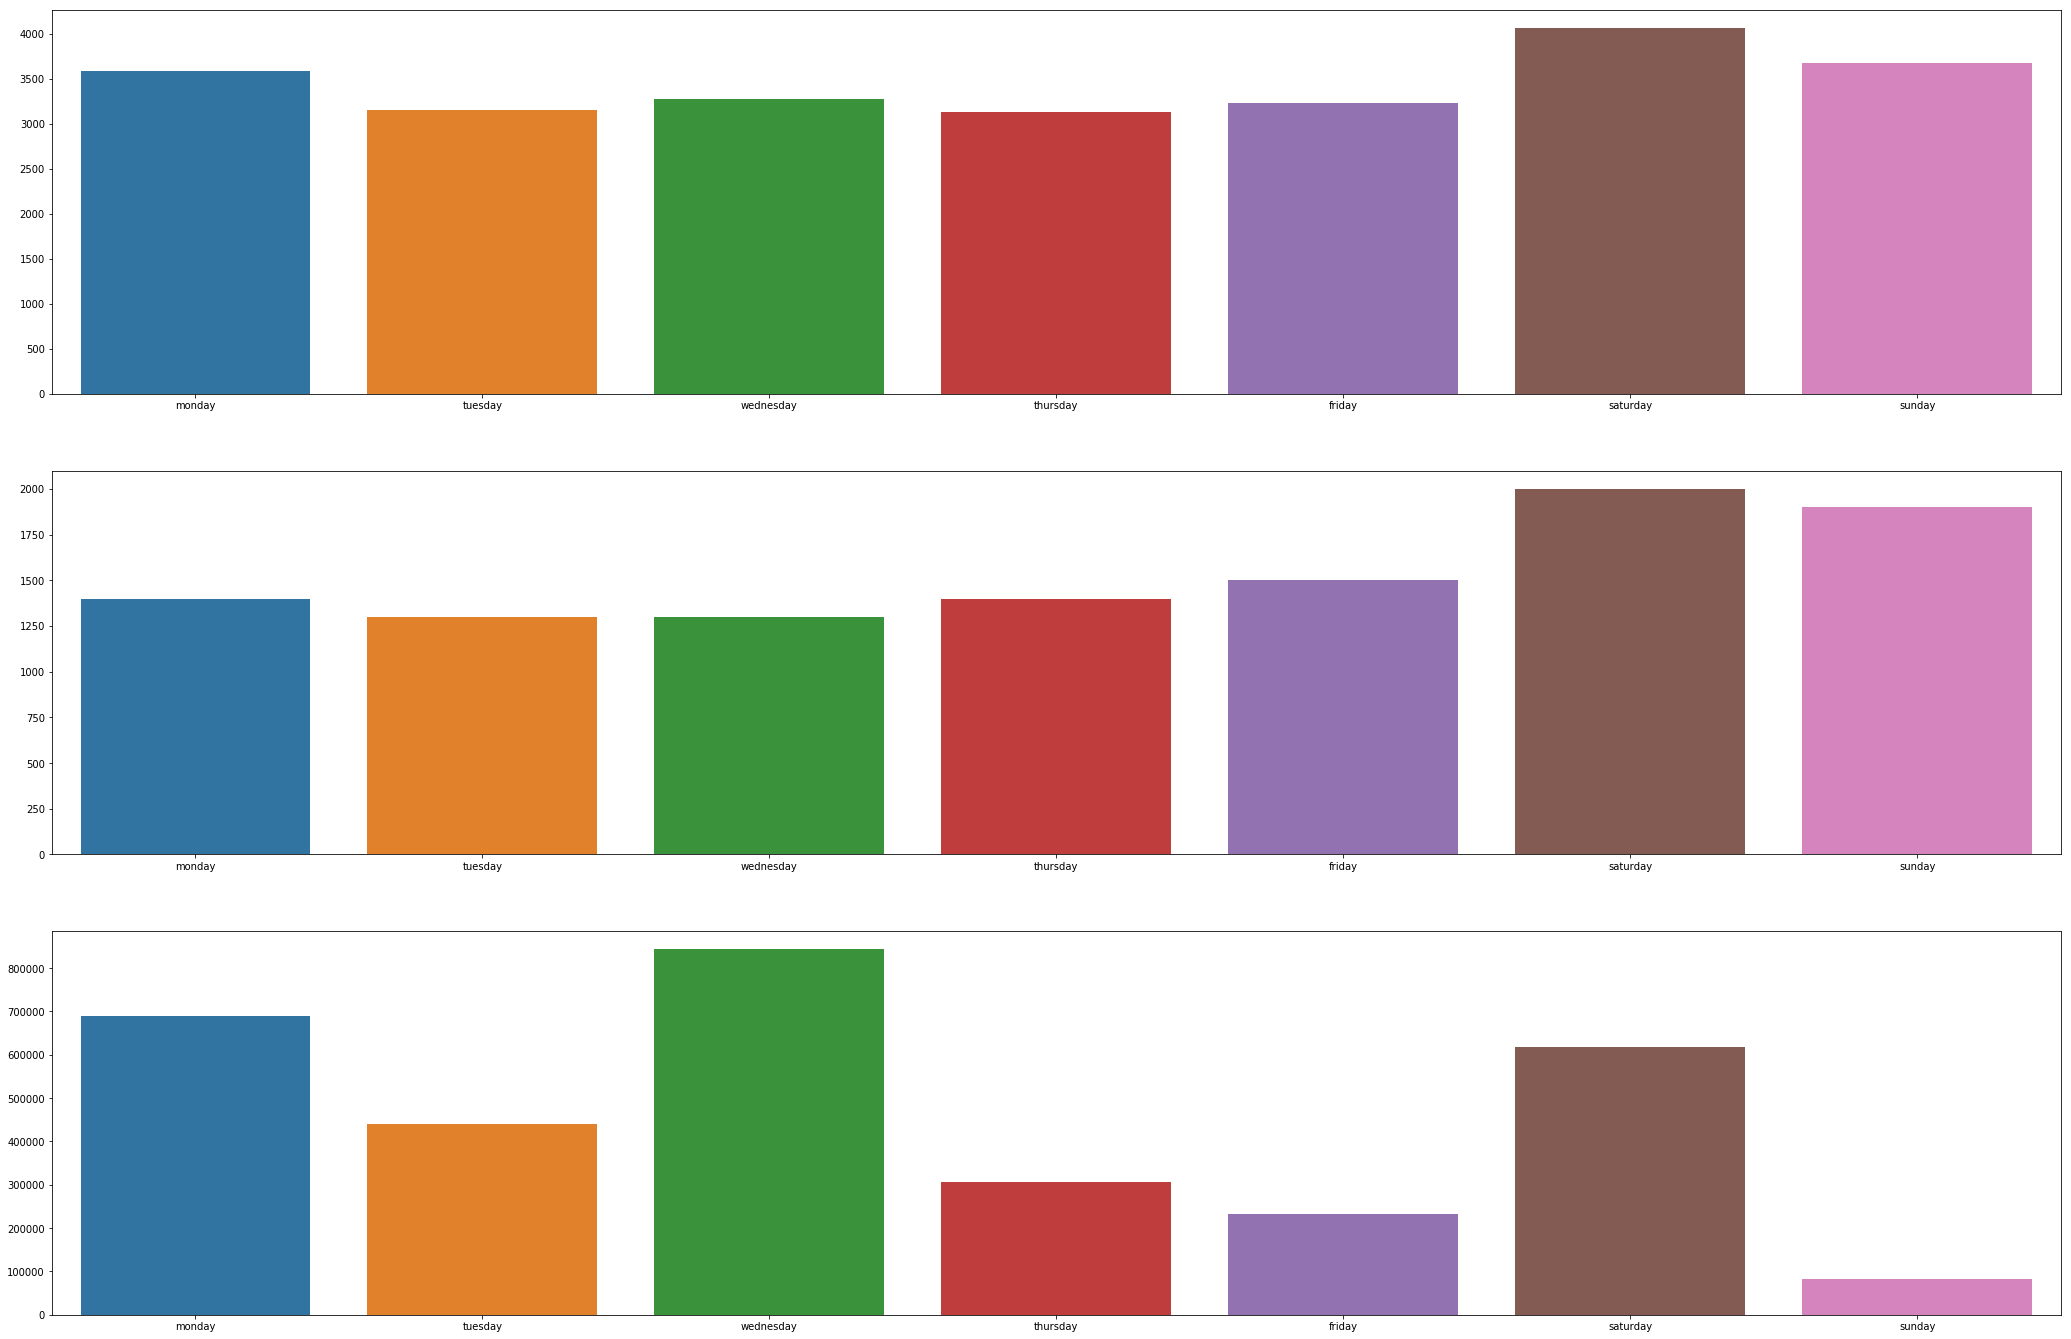

In [16]:
weekday_list = ['monday', 'tuesday','wednesday','thursday','friday','saturday','sunday']
mean_list = []
median_list = []
max_list = []
for i, day in enumerate(weekday_list):
    day_data = cleaned_data[cleaned_data[' weekday_is_' + str(day)] == 1]
    mean_list.append(day_data[' shares'].mean())
    median_list.append(day_data[' shares'].median())
    max_list.append(max(day_data[' shares']))
fig,ax = plt.subplots(nrows = 3, ncols = 1, figsize = (36,24))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
sns.barplot(x= weekday_list, y = mean_list, ax=ax[0])
sns.barplot(x = weekday_list, y = median_list, ax = ax[1])
sns.barplot(x = weekday_list, y = max_list, ax = ax[2])

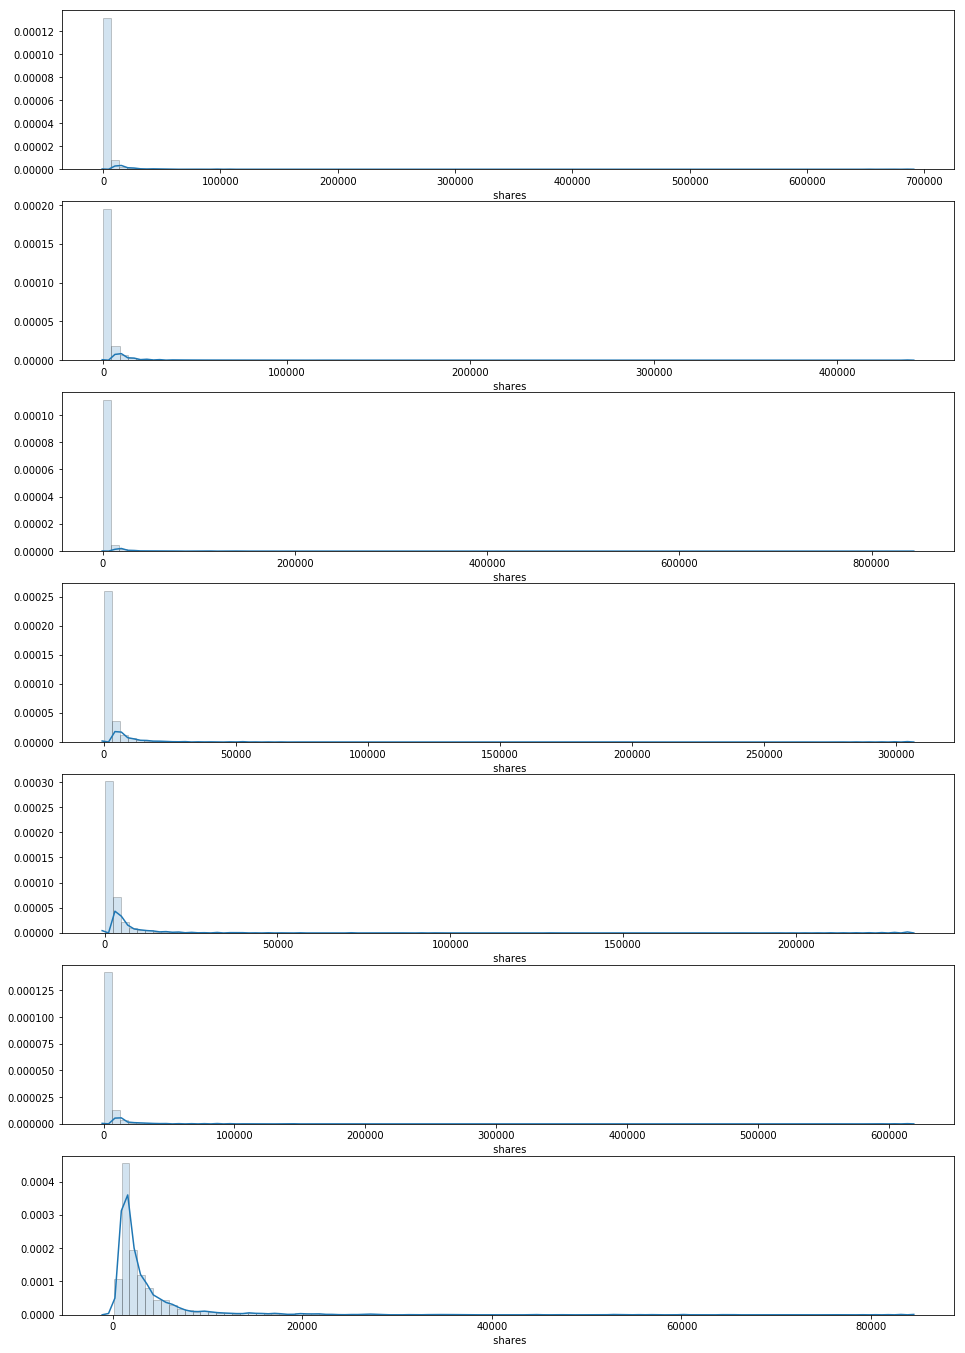

In [17]:
weekday_list = ['monday', 'tuesday','wednesday','thursday','friday','saturday','sunday']
fig,ax = plt.subplots(nrows = 7, ncols = 1, figsize = (16,24))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}

for i, day in enumerate(weekday_list):
    day_data = cleaned_data[cleaned_data[' weekday_is_' + str(day)] == 1]
    sns.distplot(a=day_data[' shares'], bins = 100, ax=ax[i], hist_kws = hist_kws)


### For different tokens visualization

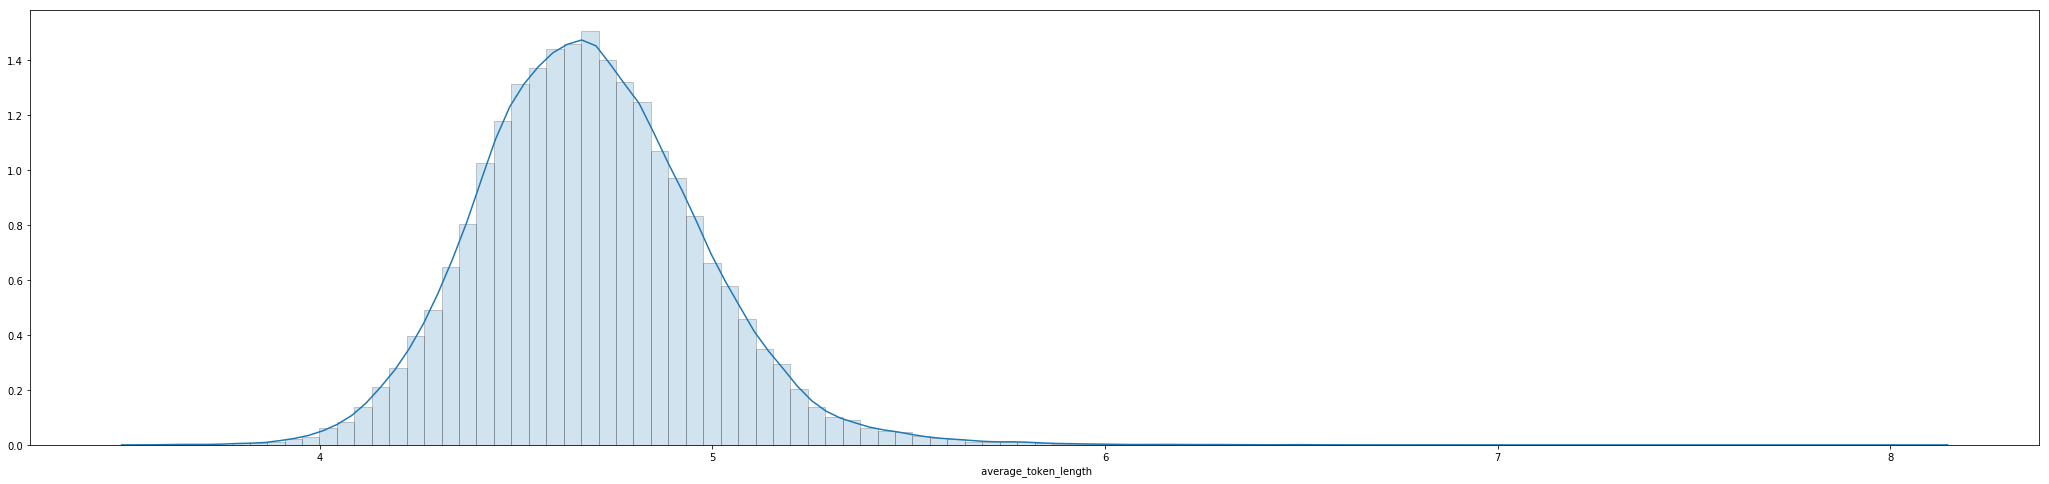

In [19]:

token_length = cleaned_data[[' average_token_length', ' shares']]
fig,ax = plt.subplots(figsize = (36,8))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
#plt.plot(token_length[' average_token_length'], token_length[' shares'], '.')
sns.distplot(a =token_length[' average_token_length'], bins = 100, ax=ax, hist_kws = hist_kws)


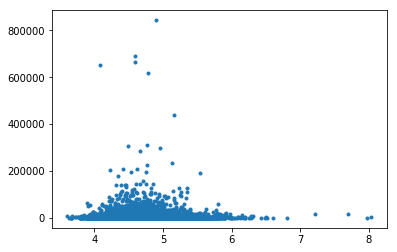

In [20]:
plt.plot(token_length[' average_token_length'], token_length[' shares'], '.')


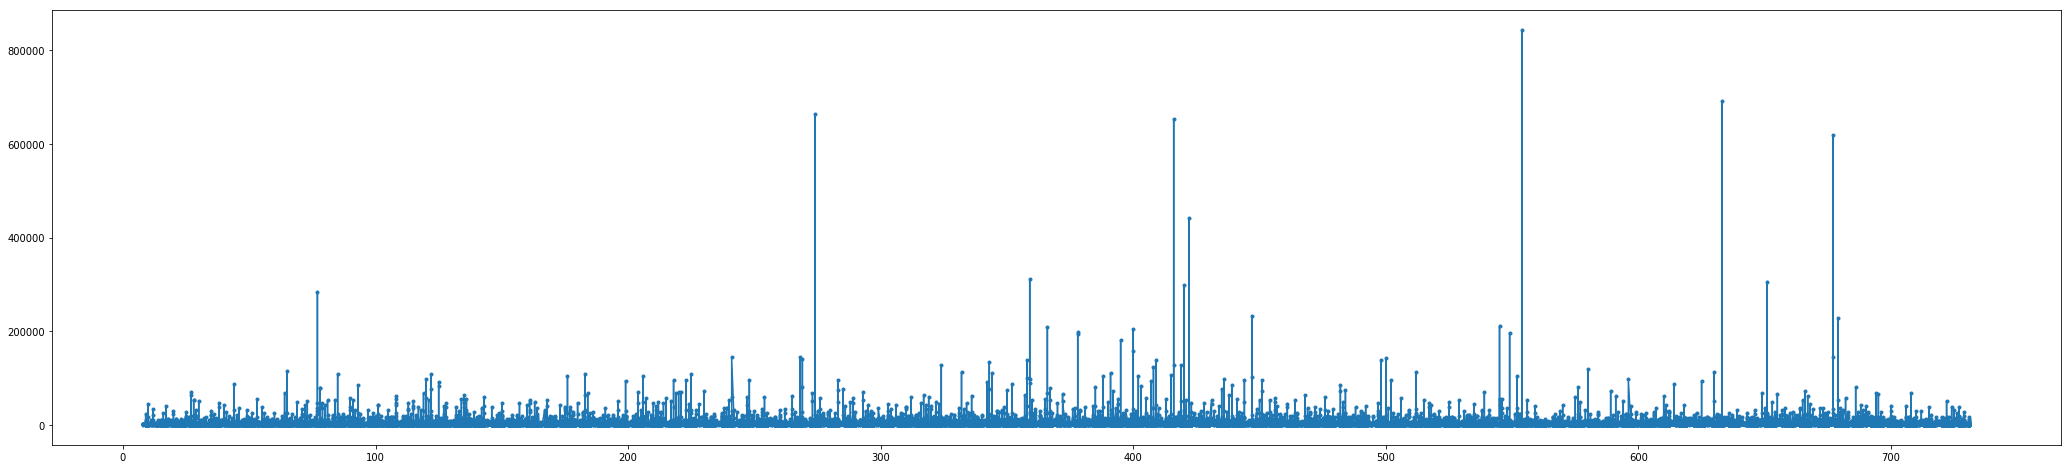

In [21]:
#Time delta 
feature_data = cleaned_data[[' timedelta', ' shares']]
fig, ax = plt.subplots(figsize = (36,8))
hist_kws = hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
#sns.distplot(a =feature_data[' timedelta'], bins = 100, ax=ax, hist_kws = hist_kws)
plt.plot(feature_data[' timedelta'], feature_data[' shares'], '.-')

In [ ]:
from sklearn.preprocessing import StandardScaler


In [22]:
def normalize(df):
    return (df-df.mean())/(df.max() - df.min())

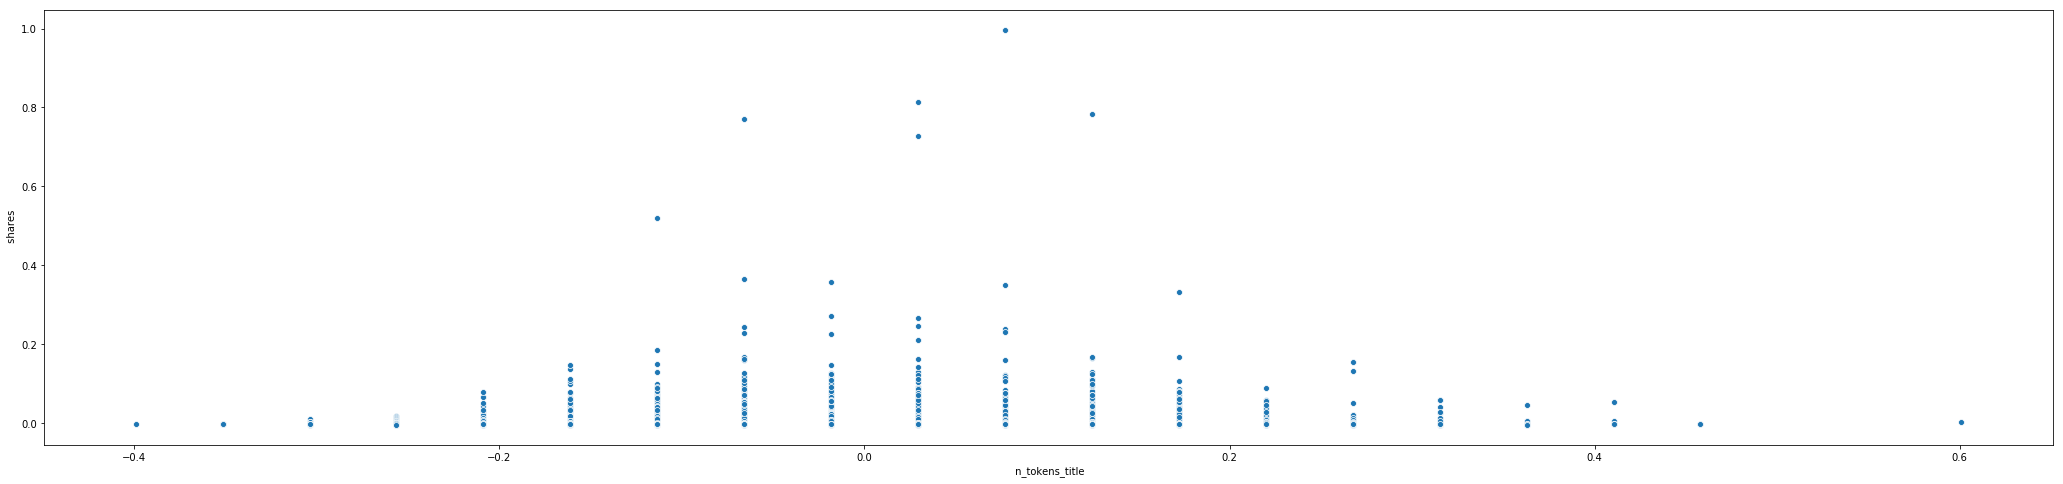

In [24]:
#Time delta 
feature_data = cleaned_data[[' n_tokens_title', ' shares']]
feature_data = normalize(feature_data)
fig, ax = plt.subplots(figsize = (36,8))
hist_kws = hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
sns.scatterplot(x =' n_tokens_title', y = ' shares', data = feature_data,  ax=ax)
#plt.plot(feature_data[' timedelta'], feature_data[' shares'], '.-')

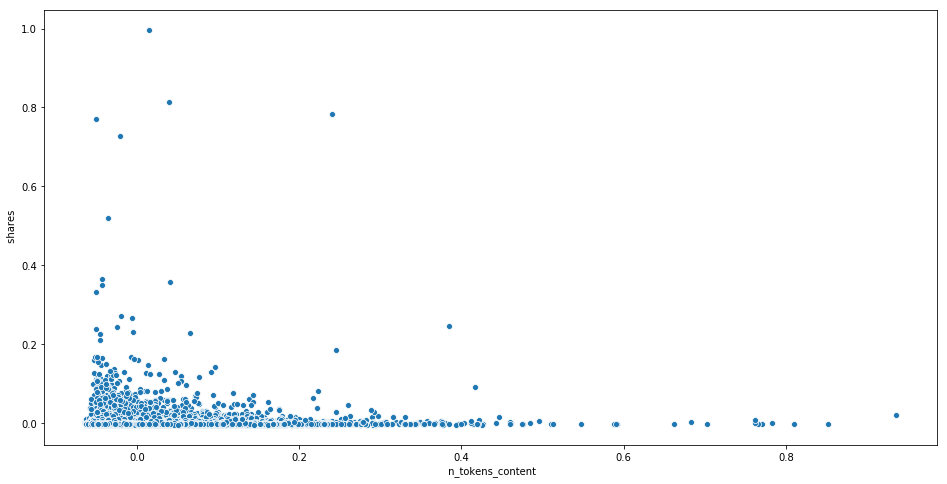

In [25]:
#Time delta 
feature_data = cleaned_data[[' n_tokens_content', ' shares']]
feature_data = normalize(feature_data)
fig, ax = plt.subplots(figsize = (16,8))
hist_kws = hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
sns.scatterplot(x =' n_tokens_content', y = ' shares', data = feature_data,  ax=ax)
#plt.plot(feature_data[' timedelta'], feature_data[' shares'], '.-')

In [31]:
feature_list = cleaned_data.columns.values

In [33]:
cleaned_data = cleaned_data.reindex(index = range(0, len(cleaned_data)))
category_list = ['lifestyle','entertainment', 'bus', 'socmed', 'tech', 'world']
feature_list = cleaned_data.columns.values
no_cat_data = cleaned_data.drop(feature_list[12:18],1)
lif_data = no_cat_data[cleaned_data[' data_channel_is_lifestyle'] == 1]
ent_data = no_cat_data[cleaned_data[' data_channel_is_entertainment'] == 1]
bus_data = no_cat_data[cleaned_data[' data_channel_is_bus'] == 1]
soc_data = no_cat_data[cleaned_data[' data_channel_is_socmed'] == 1]
tec_data = no_cat_data[cleaned_data[' data_channel_is_tech'] == 1]
world_data = no_cat_data[cleaned_data[' data_channel_is_world'] == 1]

In [ ]:
no_cat_data[' category'] = list(np.zeros(len(no_cat_data)))
for i in range(0, len(no_cat_data)):
    #print(i)
    if cleaned_data.loc[i][' data_channel_is_lifestyle'] == 1:
        no_cat_data.loc[i][' category'] = 0
    elif cleaned_data.loc[i][' data_channel_is_entertainment'] == 1:
        no_cat_data.loc[i][' category'] = 1
    elif cleaned_data.loc[i][' data_channel_is_bus'] == 1:
        no_cat_data.loc[i][' category'] = 2
    elif cleaned_data.loc[i][' data_channel_is_socmed'] == 1:
        no_cat_data.loc[i][' category'] = 3
    elif cleaned_data.loc[i][' data_channel_is_tech'] == 1:
        no_cat_data.loc[i][' category'] = 4
    else:
        no_cat_data.loc[i][' category'] = 5



NameError: name 'no_cat_data' is not defined

In [ ]:
#Time delta 
feature_data = cleaned_data[[' num_keywords', ' shares']]
feature_data = normalize(feature_data)
fig, ax = plt.subplots(figsize = (16,8))
hist_kws = hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
sns.scatterplot(x =' num_keywords', y = ' shares', data = feature_data,  ax=ax)
#plt.plot(feature_data[' timedelta'], feature_data[' shares'], '.-')

In [ ]:
feature_data =no_cat_data[[' category', ' shares']]
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = ' category', y = ' shares', data = no_cat_data, ax=ax)

In [39]:
reference_data=cleaned_data[[' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess',' shares']]

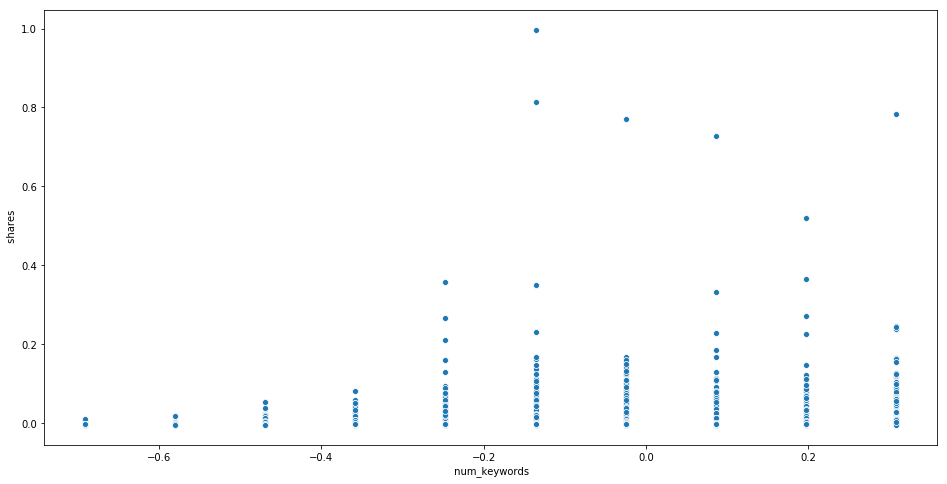

In [40]:
#reference shares
feature_data = cleaned_data[[' num_keywords', ' shares']]
feature_data = normalize(feature_data)
fig, ax = plt.subplots(figsize = (16,8))
hist_kws = hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
sns.scatterplot(x =' num_keywords', y = ' shares', data = feature_data,  ax=ax)
#plt.plot(feature_data[' timedelta'], feature_data[' shares'], '.-')

### Different models:
------
1. Decision Tree(base)
2. AdaBoostClassifer
3. Random Forest
4. Grandient Boosting
5. xgb

In [ ]:
cleaned_data.columns

### Clean the data and decide which feature to include

In [185]:
cleaned_data = cleaned_data[~cleaned_data[' month'].isna()]

In [186]:
#cleaned_data.drop([' year', ' date'],1)
month_list = ['jan', 'feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

for j,month in enumerate(month_list):
    var_name = ' month_is_' + str(month)
    temp_list = []
    for i in range(len(cleaned_data)):
        #print(i)
        if int(cleaned_data.iloc[i][' month']) == (j+1):
            temp_list.append(1)
        else:
            temp_list.append(0)
    cleaned_data[var_name] = temp_list


In [187]:
model_data = cleaned_data.drop(' year', 1)
model_data = model_data.drop(' month',1)
model_data = model_data.drop(' date',1)

In [188]:
threshold = 1400
target = []
for i in range(len(model_data)):
    if model_data.iloc[i][' shares'] >= threshold:
        target.append(1)
    else:
        target.append(0)
class_data = model_data.drop(' shares', 1)
class_data['target'] = target


### I will be specifically focusing on ensemble methods. 
For ensemble methods, I started with the basic decision tree methods, tune the parameters. Then ensembled them by adaboost, gradient tree boosting and random forest


### AdaBoost methods 

In [649]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

estimator = DecisionTreeClassifier(max_depth = 10)#Can be tuned
ada_classifier = AdaBoostClassifier(estimator)
X  = class_data.drop('target', 1)
y = class_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, shuffle = True)




In [650]:
ada_classifier.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [651]:
ada_classifier.score(X_test, y_test)

0.590868962038088

In [652]:
ada_classifier.score(X_test, y_test)

0.590868962038088

In [653]:
fpr, tpr,_ = metrics.roc_curve(y_test, ada_classifier.predict_proba(X_test)[:,1])
auc_ada_orig = metrics.auc(fpr, tpr)
auc_ada_orig

0.6264318327075942

In [28]:
importance = sorted(zip(class_data.columns.values[:-1], ada_classifier.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:30s} | {1:5F}'.format(feature, val))

 kw_max_avg                    | 0.038768
 global_subjectivity           | 0.036470
 kw_avg_min                    | 0.036016
 average_token_length          | 0.035915
 LDA_00                        | 0.034102
 kw_avg_max                    | 0.034033
 avg_positive_polarity         | 0.033497
 global_rate_positive_words    | 0.033412
 kw_avg_avg                    | 0.032855
 timedelta                     | 0.032625
 LDA_04                        | 0.031531
 global_rate_negative_words    | 0.030775
 n_non_stop_unique_tokens      | 0.030755
 LDA_01                        | 0.030048
 global_sentiment_polarity     | 0.029474
 avg_negative_polarity         | 0.028037
 n_tokens_content              | 0.027375
 LDA_02                        | 0.027297
 LDA_03                        | 0.026377
 n_unique_tokens               | 0.026053
 self_reference_min_shares     | 0.025580
 kw_max_min                    | 0.023627
 num_hrefs                     | 0.023086
 kw_min_avg                    | 0

#### Hyper-parameter tuning for decision trees using grid search and cross validations

In [29]:
X = class_data.drop('target',1)
y = class_data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True)

In [33]:
param_grid_dt = {'max_depth':[10**i for i in range (1,11)], 'min_samples_leaf':[2**i for i in range(1, 11)]}
kfolds = KFold(n_splits = 5)
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv =kfolds, scoring = 'roc_auc')
dt_grid_search.fit(X_train, y_train)

best_score = dt_grid_search.best_score_
print('The best score is {}',format(best_score))
print('The best estimator config is {}'.format(dt_grid_search.best_estimator_))

The best score is {} 0.6969529727688387
The best estimator config is DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=256, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [34]:
dt_grid_search.score(X_test, y_test)

0.6853880918562124

### AdaBoost classifier using the best configuration of Decision Trees. Still using grid search and cross validation to tune the hyper parameters

In [142]:
X  = class_data.drop('target', 1)
y = class_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)


In [146]:
learning_rate_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
kfolds = KFold(n_splits = 5)
param_grid_ad = {'n_estimators':[50*i for i in range(1, 6)], 'learning_rate':learning_rate_list}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
ad_grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)), param_grid_ad, cv = kfolds, scoring = 'roc_auc') 
ad_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = ad_grid_search.best_score_
print(best_1)

0.7405097505657301


In [147]:
ad_grid_search.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=256, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.03, n_estimators=250, random_state=None)

In [148]:
ad_grid_search.score(X_test, y_test)

0.7472859441206778

### Gradient Tree Boosting methods

In [662]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score

X  = class_data.drop('target', 1)
y = class_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)


n_est_lim = 1000
gb_classifier = GradientBoostingClassifier(n_estimators = n_est_lim, max_depth = 10)
gb_classifier.fit(X_train, y_train)




GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [663]:
gb_classifier.score(X_test, y_test)

0.6691890528439904

In [664]:
fpr, tpr,_ = metrics.roc_curve(y_test, gb_classifier.predict_proba(X_test)[:,1])
auc_gb_orig = metrics.auc(fpr, tpr)
auc_gb_orig

0.7308185950942632

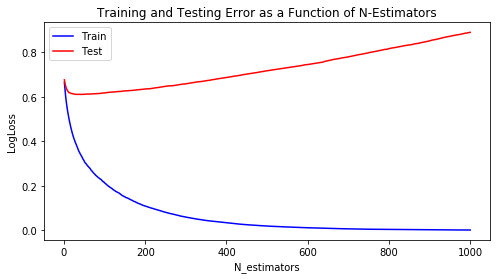

In [666]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4


def LogLossP(Pt, Yt):
    return -1*((Yt==1)*np.log(Pt)+(Yt==0)*np.log(1-Pt)).mean()

p_train = gb_classifier.staged_predict_proba(X_train)
p_test = gb_classifier.staged_predict_proba(X_test)

train_list = []
test_list = []

for p in p_train:
    train_list.append(LogLossP(p[:, 1], y_train))
    
for p in p_test:
    test_list.append(LogLossP(p[:, 1], y_test))
    

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, n_est_lim + 1), train_list, 'b-', label='Train')
plt.plot(np.arange(1, n_est_lim + 1), test_list, 'r-', label='Test')
plt.title('Training and Testing Error as a Function of N-Estimators')
plt.legend()
plt.xlabel('N_estimators')
plt.ylabel('LogLoss')
plt.savefig('training_error of n_estimators.png')

In [149]:
learning_rate_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
kfolds = KFold(n_splits = 5)
param_grid_gb = {'n_estimators':[50*i for i in range(1, 6)], 'learning_rate':learning_rate_list}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
gb_grid_search = GridSearchCV(GradientBoostingClassifier(max_depth = 10), param_grid_gb, cv = kfolds, scoring = 'roc_auc') 
gb_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = gb_grid_search.best_score_
print(best_1)

0.7311842749896564


In [152]:
best_l = gb_grid_search.best_score_

In [151]:
gb_grid_search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [153]:
best_l

0.7311842749896564

In [154]:
gb_grid_search.score(X_test, y_test)

0.7419894700743146

### RandomForest Classifiers:

In [403]:
X  = class_data.drop('target', 1)
y = class_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

In [405]:
from sklearn.ensemble import RandomForestClassifier

In [406]:
kfolds = KFold(n_splits = 5)
param_grid_rf = {'n_estimators':[50*i for i in range(1, 6)], 'max_features':[2*j for j in range(1,6)]}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv = kfolds, scoring = 'roc_auc') 
rf_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = rf_grid_search.best_score_
print(best_1)

0.7302976794234408


In [407]:
rf_grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X  = class_data.drop('target', 1)
y = class_data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True)
estimator = RandomForestClassifier(n_estimators=100)
#clf.fit(X_train, y_train)
selector = RFE(estimator, n_features_to_select = 20, step=0.8)
selector = selector.fit(X_train, y_train)



In [17]:
selector.score(X_test, y_test)

0.6528591897876774

In [18]:
selector.n_features_

20

In [20]:
len(selector.ranking_)

71

In [21]:
importance = sorted(zip(class_data.columns.values[:-1], selector.ranking_), key=lambda x:x[1], reverse=False)
for feature, val in importance:
    print('{0:30s} | {1:5F}'.format(feature, val))

 timedelta                     | 1.000000
 n_tokens_content              | 1.000000
 n_unique_tokens               | 1.000000
 n_non_stop_unique_tokens      | 1.000000
 average_token_length          | 1.000000
 kw_avg_min                    | 1.000000
 kw_avg_max                    | 1.000000
 kw_max_avg                    | 1.000000
 kw_avg_avg                    | 1.000000
 self_reference_min_shares     | 1.000000
 self_reference_avg_sharess    | 1.000000
 LDA_00                        | 1.000000
 LDA_01                        | 1.000000
 LDA_02                        | 1.000000
 LDA_03                        | 1.000000
 LDA_04                        | 1.000000
 global_subjectivity           | 1.000000
 global_sentiment_polarity     | 1.000000
 global_rate_positive_words    | 1.000000
 avg_positive_polarity         | 1.000000
 n_tokens_title                | 2.000000
 n_non_stop_words              | 2.000000
 num_hrefs                     | 2.000000
 num_self_hrefs                | 2

In [22]:
importance

[(' timedelta', 1),
 (' n_tokens_content', 1),
 (' n_unique_tokens', 1),
 (' n_non_stop_unique_tokens', 1),
 (' average_token_length', 1),
 (' kw_avg_min', 1),
 (' kw_avg_max', 1),
 (' kw_max_avg', 1),
 (' kw_avg_avg', 1),
 (' self_reference_min_shares', 1),
 (' self_reference_avg_sharess', 1),
 (' LDA_00', 1),
 (' LDA_01', 1),
 (' LDA_02', 1),
 (' LDA_03', 1),
 (' LDA_04', 1),
 (' global_subjectivity', 1),
 (' global_sentiment_polarity', 1),
 (' global_rate_positive_words', 1),
 (' avg_positive_polarity', 1),
 (' n_tokens_title', 2),
 (' n_non_stop_words', 2),
 (' num_hrefs', 2),
 (' num_self_hrefs', 2),
 (' num_imgs', 2),
 (' num_videos', 2),
 (' num_keywords', 2),
 (' data_channel_is_lifestyle', 2),
 (' data_channel_is_entertainment', 2),
 (' data_channel_is_bus', 2),
 (' data_channel_is_socmed', 2),
 (' data_channel_is_tech', 2),
 (' data_channel_is_world', 2),
 (' kw_min_min', 2),
 (' kw_max_min', 2),
 (' kw_min_max', 2),
 (' kw_max_max', 2),
 (' kw_min_avg', 2),
 (' self_referenc

In [45]:
model_data.columns

Index([' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_p

In [497]:
from xgboost.sklearn import XGBClassifier

In [615]:
xgb_orig = XGBClassifier()
xgb_orig.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [618]:
xgb_orig.score(X_train,y_train)

0.6883493615008671

In [619]:
fpr, tpr,_ = metrics.roc_curve(y_test, xgb_orig.predict_proba(X_test)[:,1])
auc = metrics.auc(fpr, tpr)


In [620]:
auc

0.742305354067718

In [625]:
learning_rate_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]

kfolds = KFold(n_splits = 5)
param_grid_xgb = {'learning_rate':learning_rate_list, 'n_estimators':[50*i for i in range(1, 6)]}

xgb_grid_search = GridSearchCV(XGBClassifier(max_depth = 10), param_grid_xgb, cv = kfolds, scoring = 'roc_auc') 
xgb_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = xgb_grid_search.best_score_
print(best_1)


0.7346052597547197


In [626]:
xgb_grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

We have compared with different lists of feature importances, and came up with teh following 15 features that played major roles in different classifiers/regressions. We chose these features not only based on their feature importance numeric values, but we also take into considerations of the different categories of features: mainly in 3 categories: publishing time, text analysis, topic/subject analysis.

We will be using our best classifier configurations to test on these major features. However, for emsemble methods, it does not have big difference testing on whole set of features and selected subset of features due to the property of hte emsemble methods, it is not likely that the classifier will overfit data seriously. 

1. kw_max_avg
2. kw_avg_avg
3. LDA_02
4. self_reference_min_shares
5. is_weekend 
6. kw_min_avg
7. data_channel_is_world
8. LDA_04
9. average_token_length
10. global_subjectivity
11. global_rate_positive_words
12. n_non_stop_unique_token
13. n_unique_token
14. global_sentiment_polarity
15. LDA_00 

In [ ]:
candidate_features = [[' kw_max_avg', ' LDA_02', ' self_reference_min_shares', ' is_weekend', ' kw_min_avg',
                      ' data_channel_is_world', ' LDA_04',' average_token_length',' global_subjectivity', 
                       ' global_rate_positive_words',' n_non_stop_unique_token', ' n_unqiue_token', 
                       ' global_sentiment_polarity',' LDA_00',' shares']]

### Greedy methods to figure out the best subset of features
1. a very thorough methods to find the best subset. However, it is not guaranteed that the subset found is the best one for entire data configurations
2. We will use the metrics that improves the mean error differed by 1 std. Also, the loss function is log loss functions
3. reference: Brian Delassore feature selections

In [ ]:
for train_index, test_index in kfolds.split(orig_data):
    X_train = orig_data.iloc[train_index]
    X_test = orig_data.iloc[test_index]

In [277]:
def LogLoss(predict_prob, truth):
    return ((-1*(np.log(predict_prob))*(truth == 1) - (np.log(1-predict_prob))*(truth == 0)).mean())

In [305]:
X = class_data.drop('target',1)
y = class_data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = False)

In [302]:
for train_index, test_index in kfolds.split(X_train):
    temp = train_index
    X_train_sub = X_train.loc[train_index]
#     X_val = X_train.iloc[test_index]
#     y_train = y_train.iloc[train_index]
#     y_val = y_train.iloc[test_index]

In [318]:
def train_iter(X_train, y_train):#X_trian here refers to the training set after the train_test split
    kfolds = KFold(n_splits = 5)
    loss_list = []
    for train_index, test_index in kfolds.split(X_train):
        X_train_sub = X_train.loc[train_index]
        X_val = X_train.loc[test_index]
        y_train_sub = y_train.loc[train_index]
        y_val = y_train.loc[test_index]
        
        estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)#Can be tuned
        ada_classifier = AdaBoostClassifier(estimator,n_estimators = 200, learning_rate = 0.03)
        ada_classifier.fit(X_train_sub, y_train_sub)
        predict_prob = ada_classifier.predict_proba(X_val)[:,1]
        
        log_loss = LogLoss(predict_prob, y_val)
        loss_list.append(log_loss)
        
    return (np.mean(loss_list), np.std(loss_list)/np.sqrt(len(loss_list)) )#standard deviation of the mean
        

In [335]:
def LrForward_LogLoss(X_train, y_train):
    results = {}
    curr_best = set()
    cand_list = set(X_train.columns.values)
    k = 1
    
    curr_best_mu = 10**10
    curr_best_serr = 10**10
    while True:
        prev_best_mu = curr_best_mu
        prev_best_serr = curr_best_serr
        for f in cand_list:
            use_x = list(curr_best) + [f]
            mu, serr = train_iter(X_train[use_x], y_train)
            if ((mu + serr) < (curr_best_mu + curr_best_serr)):
                curr_best_mu = mu
                curr_best_serr = serr
                best_f = f
        '''
        Now we have a curr_best_mu that is among all the one added. We first decide whether the improvement is substantial
        If the new best curr_best_mu is only slightly better than the previous one, we will just stop
        and take whatever is chose. 
        '''
        temp_prev = abs(prev_best_mu+ prev_best_serr)
        temp_curr = abs(curr_best_mu + curr_best_serr)
        print('The current prev and curr is {},{}'.format(temp_prev,temp_curr ))
        if  (abs((prev_best_mu+ prev_best_serr) - (curr_best_mu+curr_best_serr)) <= 0.00001):
            break;
        #If not, then add in the new best feature.
        curr_best.add(best_f) #Add the best feature to the curr_best_set
        cand_list = cand_list.difference(curr_best) #Remove the best feature from the candidate set
        results[k] = [list(curr_best), curr_best_mu, curr_best_serr]
        
    return results
            

In [336]:
results = LrForward_LogLoss(X_train, y_train)

The current prev and curr is 20000000000,0.6872058085229162
The current prev and curr is 0.6872058085229162,0.6835610040187384
The current prev and curr is 0.6835610040187384,0.6805297388087604
The current prev and curr is 0.6805297388087604,0.6778797857527964
The current prev and curr is 0.6778797857527964,0.6756583047666261
The current prev and curr is 0.6756583047666261,0.6735800429701337
The current prev and curr is 0.6735800429701337,0.6714638770280056
The current prev and curr is 0.6714638770280056,0.6699201291637892
The current prev and curr is 0.6699201291637892,0.6687694504576575
The current prev and curr is 0.6687694504576575,0.6673835351434807
The current prev and curr is 0.6673835351434807,0.6666742056924484
The current prev and curr is 0.6666742056924484,0.6661440811888256
The current prev and curr is 0.6661440811888256,0.6658651220382541
The current prev and curr is 0.6658651220382541,0.6653979829144889
The current prev and curr is 0.6653979829144889,0.6651185139623802
Th

In [337]:
results

{1: [[' kw_avg_max',
   ' LDA_00',
   ' LDA_01',
   ' global_subjectivity',
   ' month_is_jan',
   ' kw_avg_avg',
   ' data_channel_is_socmed',
   ' num_videos',
   ' LDA_02',
   ' timedelta',
   ' data_channel_is_lifestyle',
   ' n_unique_tokens',
   ' is_weekend',
   ' LDA_03',
   ' kw_min_avg',
   ' LDA_04',
   ' min_positive_polarity',
   ' data_channel_is_entertainment',
   ' month_is_oct',
   ' self_reference_avg_sharess',
   ' self_reference_min_shares',
   ' num_hrefs'],
  0.6622736970169243,
  0.0016453662205269907]}

In [366]:
key_features = list(results[1][0])
key_features.append('target')

In [367]:
feature_selected_data = class_data[key_features]

Now use the best configuration of each tree-based model to get results, based on metrics of auc and also F1-SCORE
1. decision trees
2. adaboosting
3. gradient tree boosting
4. random forest

In [388]:
X_fs = feature_selected_data.drop('target', 1)
y_fs = feature_selected_data['target']
AUCs = []
fprs = []
tprs = []
f1_scores = []

In [370]:
#Decision Tree
X_train_fs, X_test_fs, y_train_fs,y_test_fs = train_test_split(X_fs, y_fs, test_size = 0.2)
dt_fs = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
dt_fs.fit(X_train_fs, y_train_fs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=256, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [371]:
dt_fs.score(X_test_fs, y_test_fs)

0.6509017530583933

In [389]:
f1_score = metrics.f1_score(y_test_fs, dt_fs.predict(X_test_fs))
fpr, tpr,_ = metrics.roc_curve(y_test_fs, dt_fs.predict_proba(X_test_fs)[:,1])
auc = metrics.auc(fpr, tpr)
f1_scores.append(f1_score)
fprs.append(fpr)
tprs.append(tpr)
AUCs.append(auc)

In [391]:
#AdaBoosting:
estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_fs = AdaBoostClassifier(estimator, learning_rate =0.03, n_estimators = 250)
ad_fs.fit(X_train_fs, y_train_fs)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=256, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.03, n_estimators=250, random_state=None)

In [392]:
ad_fs.score(X_test_fs, y_test_fs)

0.6802875520242149

In [393]:
f1_score = metrics.f1_score(y_test_fs, ad_fs.predict(X_test_fs))
fpr, tpr,_ = metrics.roc_curve(y_test_fs, ad_fs.predict_proba(X_test_fs)[:,1])
auc = metrics.auc(fpr, tpr)
f1_scores.append(f1_score)
fprs.append(fpr)
tprs.append(tpr)
AUCs.append(auc)

In [396]:
#Gradient Boosting Classifier
gb_fs = GradientBoostingClassifier(max_depth = 10, learning_rate = 0.03, n_estimators = 250)
gb_fs.fit(X_train_fs, y_train_fs)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [397]:
gb_fs.score(X_test_fs, y_test_fs)

0.6749905410518351

In [398]:
f1_score = metrics.f1_score(y_test_fs, gb_fs.predict(X_test_fs))
fpr, tpr,_ = metrics.roc_curve(y_test_fs, gb_fs.predict_proba(X_test_fs)[:,1])
auc = metrics.auc(fpr, tpr)
f1_scores.append(f1_score)
fprs.append(fpr)
tprs.append(tpr)
AUCs.append(auc)

In [452]:
#Random Forest:
rf_fs = RandomForestClassifier(n_estimators = 250,max_features = 6)
rf_fs.fit(X_train_fs, y_train_fs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [456]:
rf_fs.score(X_test_fs, y_test_fs)
f1_score = metrics.f1_score(y_test_fs, rf_fs.predict(X_test_fs))
fpr, tpr,_ = metrics.roc_curve(y_test_fs, rf_fs.predict_proba(X_test_fs)[:,1])
auc = metrics.auc(fpr, tpr)
f1_scores.append(f1_score)
fprs.append(fpr)
tprs.append(tpr)
AUCs.append(auc)

In [506]:
#XGBoost
xgb_fs = XGBClassifier(max_depth = 10, learning_rate = 0.03, n_estimators = 250)
xgb_fs.fit(X_train_fs, y_train_fs)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [508]:
xgb_fs.score(X_test_fs, y_test_fs)

0.6758733762138983

In [507]:
#rf_fs.score(X_test_fs, y_test_fs)
f1_score = metrics.f1_score(y_test_fs, xgb_fs.predict(X_test_fs))
fpr, tpr,_ = metrics.roc_curve(y_test_fs, xgb_fs.predict_proba(X_test_fs)[:,1])
auc = metrics.auc(fpr, tpr)
f1_scores.append(f1_score)
fprs.append(fpr)
tprs.append(tpr)
AUCs.append(auc)

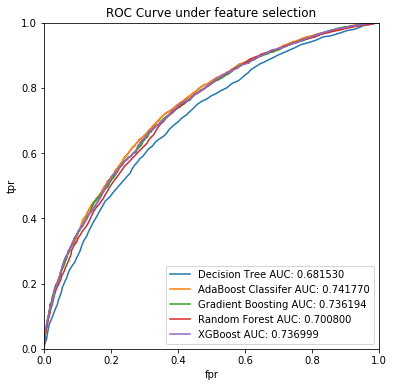

In [659]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 6,6

roc_labels = []
#roc_labels.append('Decision Tree AUC: {0:2f}'.format(AUCs[0]))
roc_labels.append('Decision Tree AUC: {0:2f}'.format(0.68153))
roc_labels.append('AdaBoost Classifer AUC: {0:2f}'.format(AUCs[1]))
roc_labels.append('Gradient Boosting AUC: {0:2f}'.format(AUCs[2]))
#roc_labels.append('Random Forest AUC: {0:2f}'.format(AUCs[3]))
roc_labels.append('Random Forest AUC: {0:2f}'.format(0.7008))
roc_labels.append('XGBoost AUC: {0:2f}'.format(AUCs[4]))
ax = plt.subplots()
for i in range(5):
    plt.plot(fprs[i], tprs[i],label = roc_labels[i])
    
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve under feature selection")
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.show()
plt.savefig('biny_class_roc.png')

### Investigate on the distribution of shares
1. Have 3 methods of dividing the three classes.
2. Use the best features selected and the best models configurations to see the accuracy and AUC, ROC F1score
3. Compare the result. 

In [674]:
share_data = model_data[' shares']

In [675]:
maj_share = []
for share in share_data:
    if share < 20000:
        maj_share.append(share)

It is apparent that the share data has a long tail distribution, while most data concentrates on in the range of (0,200000)

In [676]:
extreme_class = []
for share in share_data:
    if share > 10000:
        extreme_class.append(share)#Only 15 articles holding shares greater than 20000
        #4813 having over 5000 shares 
    

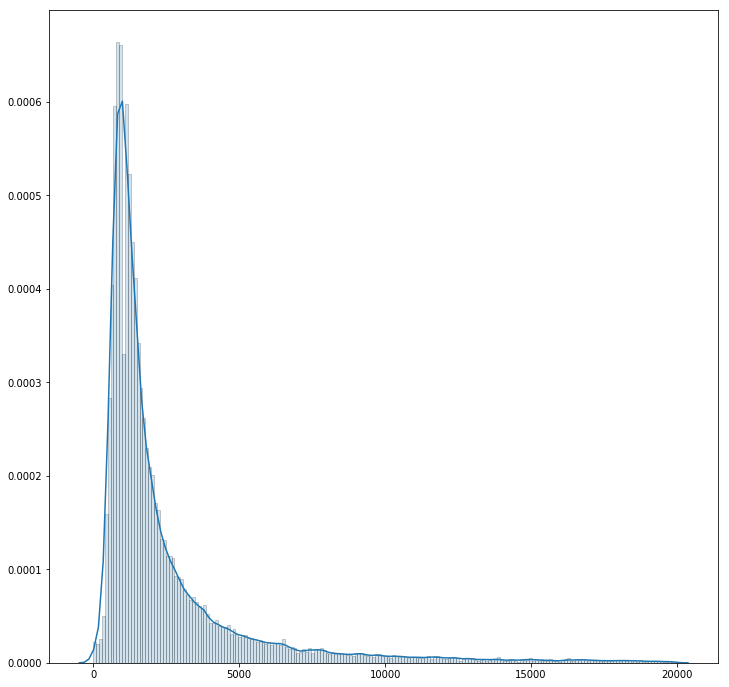

In [677]:
fig,ax = plt.subplots(figsize =(12,12))
hist_kws = hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
#plt.plot(token_length[' average_token_length'], token_length[' shares'], '.')

sns.distplot(maj_share, ax=ax, bins =200, hist_kws = hist_kws)


1st first threshold investigation: We take the quantiles as as threshold for first, second and third threshold. 


In [678]:
share_data = model_data[' shares']

In [679]:
threshold_1 = share_data.describe()['25%']
threshold_2 = share_data.describe()['75%']
threshold_1, threshold_2

(946.0, 2800.0)

In [680]:
popular_1 = []
popular_2 = []
popular_3 = []
for share in share_data:
    if share <= threshold_1:
        popular_1.append(share)
    elif share > threshold_2:
        popular_3.append(share)
    else:
        popular_2.append(share)
print('The length of 3 categories are {},{},{}'.format(len(popular_1), len(popular_2), len(popular_3)))

The length of 3 categories are 9930,20084,9630


In [681]:
target_3 = []
for share in share_data:
    if share <= threshold_1:
        target_3.append(0)
    elif share > threshold_2:
        target_3.append(2)
    else:
        target_3.append(1)

In [682]:
model_data['multi_target'] = target_3
multi_data = model_data.drop(' shares',1)

In [683]:
X_multi = multi_data.drop('multi_target',1)
y_multi = multi_data['multi_target']
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size= 0.2)

In [684]:
estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi = AdaBoostClassifier(estimator, learning_rate =0.03, n_estimators = 500)

In [685]:
ad_multi.fit(X_train_multi, y_train_multi)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=256, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.03, n_estimators=500, random_state=None)

In [692]:
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])
        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df


In [693]:
from sklearn.metrics import classification_report

report_with_auc = class_report(
    y_true=y_test_multi, 
    y_pred=ad_multi.predict(X_test_multi), 
    y_score=ad_multi.predict_proba(X_test_multi))

print(report_with_auc)

             precision    recall  f1-score  support    pred       AUC
0             0.551754  0.312469  0.398985   2013.0  1140.0  0.765080
1             0.544258  0.830738  0.657654   3982.0  6078.0  0.580210
2             0.544304  0.200103  0.292628   1934.0   711.0  0.725322
avg / total   0.546172  0.545340  0.502948   7929.0  7929.0  0.736405


In [535]:
def three_class_classifier(Xtrain, ytrain, Xtest, ytest, model):
    '''
    Assume our 3 class is labeled from 0 to 2.
    '''
    total_correct = 0
    for i in range(3):
        temp_target = ytrain.apply(lambda target: 1 if (target == i) else 0)
        temp_test = ytest.apply(lambda result: 1 if (result == i) else 0)
        #total_curr_class = temp_test.sum()
        model.fit(Xtrain, temp_target)
        prediction = model.predict(Xtest)
        result = temp_test[(prediction == temp_test) & (temp_test == 1)]#classified the current class correct
        correct = result.sum()
        total_correct += correct
    
    return (total_correct / len(ytest))

    

In [540]:
##Feed all features through adaboost with the best configuration:
estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi = AdaBoostClassifier(estimator, learning_rate =0.03, n_estimators = 500)


In [541]:
#Feed all features through adaboost with the best configuration:

#AdaBoosting:
ada_accuracy = three_class_classifier(X_train_multi, y_train_multi, X_test_multi,y_test_multi, ad_multi)

In [542]:
ada_accuracy

0.4108967082860386

In [698]:
#Feed only selected features 
#key_features.remove('target')
X_multi_fs = X_multi[key_features]
X_multi_fs_train, X_multi_fs_test, y_multi_fs_train, y_multi_fs_test = train_test_split(X_multi_fs, y_multi, test_size = 0.2)


In [700]:
estimator_fs = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi_fs = AdaBoostClassifier(estimator_fs, learning_rate =0.03, n_estimators = 500)
#ada_accuracy_fs = three_class_classifier(X_multi_fs_train, y_multi_fs_train, X_multi_fs_test, y_multi_fs_test, ad_multi_fs)
ad_multi_fs.fit(X_multi_fs_train, y_multi_fs_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=256, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.03, n_estimators=500, random_state=None)

In [701]:
report_with_auc = class_report(
    y_true=y_multi_fs_test, 
    y_pred=ad_multi_fs.predict(X_multi_fs_test), 
    y_score=ad_multi_fs.predict_proba(X_multi_fs_test))

print(report_with_auc)

             precision    recall  f1-score  support    pred       AUC
0             0.528606  0.335036  0.410128   1958.0  1241.0  0.751581
1             0.546709  0.809773  0.652733   4011.0  5941.0  0.583838
2             0.510040  0.194388  0.281492   1960.0   747.0  0.709169
avg / total   0.533174  0.540421  0.501055   7929.0  7929.0  0.728977


In [561]:
ada_accuracy_fs

0.4029511918274688

In [ ]:
#Summon up
target_3 = []
for share in share_data:
    if share <= threshold_1:
        target_3.append(0)
    elif share > threshold_2:
        target_3.append(2)
    else:
        target_3.append(1)
        
model_data['multi_target'] = target_3
multi_data = model_data.drop(' shares',1)
X_multi = multi_data.drop('multi_target',1)
y_multi = multi_data['multi_target']
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size= 0.2)

##Feed all features through adaboost with the best configuration:
estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi = AdaBoostClassifier(estimator, learning_rate =0.03, n_estimators = 250)
ada_accuracy = three_class_classifier(X_train_multi, y_train_multi, X_test_multi,y_test_multi, ad_multi)

#Feed only selected features 
X_mutli_fs = X_multi[key_features]
y_multi_fs = y_multi[key_features]


X_multi_fs_train, X_multi_ds_test, y_mutli_fs_train, y_multi_fs_test = train_test_split(X_multi_fs, y_multi_fs, test_size = 0.2)
estimator_fs = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi_fs = AdaBoostClassifier(estimator_fs, learning_rate =0.03, n_estimators = 250)
ada_accuracy_fs = three_class_classifier(X_multi_fs_train, y_multi_fs_train, X_mutli_fs_test, y_mutli_fs_test, ad_multi_fs)



2.Methods, if we divide them evenly, as we have 1/3 of data as the less popular ones, 1/3 as the most popular ones:

In [702]:
threshold_1 = np.percentile(share_data, 33)
threshold_2 = np.percentile(share_data, 66)
threshold_1, threshold_2

(1100.0, 2100.0)

In [703]:
popular_1 = []
popular_2 = []
popular_3 = []
for share in share_data:
    if share <= threshold_1:
        popular_1.append(share)
    elif share > threshold_2:
        popular_3.append(share)
    else:
        popular_2.append(share)
print('The length of 3 categories are {},{},{}'.format(len(popular_1), len(popular_2), len(popular_3)))

The length of 3 categories are 14732,11957,12955


In [704]:
#Summon up
target_3 = []
for share in share_data:
    if share <= threshold_1:
        target_3.append(0)
    elif share > threshold_2:
        target_3.append(2)
    else:
        target_3.append(1)
        
model_data['multi_target'] = target_3
multi_data = model_data.drop(' shares',1)
X_multi = multi_data.drop('multi_target',1)
y_multi = multi_data['multi_target']
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size= 0.2)

##Feed all features through adaboost with the best configuration:
estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi = AdaBoostClassifier(estimator, learning_rate =0.03, n_estimators = 500)
#ada_accuracy = three_class_classifier(X_train_multi, y_train_multi, X_test_multi,y_test_multi, ad_multi)
ad_multi.fit(X_train_multi, y_train_multi)

report_with_auc_orig = class_report(
    y_true=y_test_multi, 
    y_pred=ad_multi.predict(X_test_multi), 
    y_score=ad_multi.predict_proba(X_test_multi))

print(report_with_auc_orig)

#Feed only selected features 
X_multi_fs = X_multi[key_features]
y_multi_fs = y_multi


X_multi_fs_train, X_multi_fs_test, y_multi_fs_train, y_multi_fs_test = train_test_split(X_multi_fs, y_multi_fs, test_size = 0.2)
estimator_fs = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi_fs = AdaBoostClassifier(estimator_fs, learning_rate =0.03, n_estimators = 500)
ad_multi_fs.fit(X_multi_fs_train, y_multi_fs_train)
#ada_accuracy_fs = three_class_classifier(X_multi_fs_train, y_multi_fs_train, X_multi_fs_test, y_multi_fs_test, ad_multi_fs)

report_with_auc_fs = class_report(
    y_true=y_multi_fs_test, 
    y_pred=ad_multi_fs.predict(X_multi_fs_test), 
    y_score=ad_multi_fs.predict_proba(X_multi_fs_test))

print(report_with_auc_fs)


#print('the ada acuracy for 3 class using 1/3 division is {}, {}'.format(ada_accuracy, ada_accuracy_fs))

             precision    recall  f1-score  support    pred       AUC
0             0.569362  0.680570  0.620019   2949.0  3525.0  0.757991
1             0.423607  0.292028  0.345721   2421.0  1669.0  0.587642
2             0.516271  0.551778  0.533434   2559.0  2735.0  0.726296
avg / total   0.507723  0.520368  0.508322   7929.0  7929.0  0.701648
             precision    recall  f1-score  support    pred       AUC
0             0.568777  0.680601  0.619685   3062.0  3664.0  0.748730
1             0.394720  0.267690  0.319025   2346.0  1591.0  0.576863
2             0.521690  0.553352  0.537055   2521.0  2674.0  0.728272
avg / total   0.502307  0.517972  0.504455   7929.0  7929.0  0.698710


3rd Method: take one standard deviation away from the mean of the data. However, the std deviation of the original data is too big, which makes the threshold impossible. Hence we take the log of the shares data and get an almost normal distribution

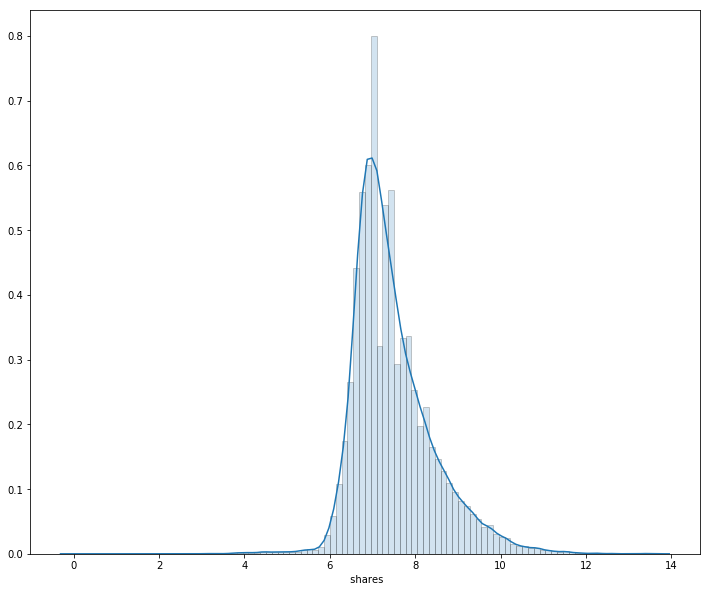

In [705]:
new_share_data = np.log(share_data)
fig, ax = plt.subplots(figsize = (12,10))
sns.distplot(new_share_data, ax=ax, bins = 100, hist_kws = hist_kws)

In [706]:
new_share_data.describe()

count    39644.000000
mean         7.474855
std          0.930486
min          0.000000
25%          6.852243
50%          7.244228
75%          7.937375
max         13.645078
Name:  shares, dtype: float64

In [707]:
threshold_1 = new_share_data.describe()['mean'] - new_share_data.describe()['std']
threshold_2 = new_share_data.describe()['mean'] + new_share_data.describe()['std']

In [708]:
threshold_1, threshold_2

(6.544368834826468, 8.405341013569293)

In [709]:
popular_1 = []
popular_2 = []
popular_3 = []
for share in new_share_data:
    if share <= threshold_1:
        popular_1.append(share)
    elif share > threshold_2:
        popular_3.append(share)
    else:
        popular_2.append(share)
print('The length of 3 categories are {},{},{}'.format(len(popular_1), len(popular_2), len(popular_3)))

The length of 3 categories are 3693,30092,5859


In [717]:
#Summon up
target_3 = []
for share in new_share_data:
    if share <= threshold_1:
        target_3.append(0)
    elif share > threshold_2:
        target_3.append(2)
    else:
        target_3.append(1)
        
model_data['multi_target'] = target_3
multi_data = model_data.drop(' shares',1)
X_multi = multi_data.drop('multi_target',1)
y_multi = multi_data['multi_target']
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size= 0.2)

##Feed all features through adaboost with the best configuration:
estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi = AdaBoostClassifier(estimator, learning_rate =0.03, n_estimators = 500)
#ada_accuracy = three_class_classifier(X_train_multi, y_train_multi, X_test_multi,y_test_multi, ad_multi)
ad_multi.fit(X_train_multi, y_train_multi)

report_with_auc_orig = class_report(
    y_true=y_test_multi, 
    y_pred=ad_multi.predict(X_test_multi), 
    y_score=ad_multi.predict_proba(X_test_multi))

print(report_with_auc_orig)

#Feed only selected features 
X_multi_fs = X_multi[key_features]
y_multi_fs = y_multi


X_multi_fs_train, X_multi_fs_test, y_multi_fs_train, y_multi_fs_test = train_test_split(X_multi_fs, y_multi_fs, test_size = 0.2)
estimator_fs = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_multi_fs = AdaBoostClassifier(estimator_fs, learning_rate =0.03, n_estimators = 500)
ad_multi_fs.fit(X_multi_fs_train, y_multi_fs_train)
#ada_accuracy_fs = three_class_classifier(X_multi_fs_train, y_multi_fs_train, X_multi_fs_test, y_multi_fs_test, ad_multi_fs)

report_with_auc_fs = class_report(
    y_true=y_multi_fs_test, 
    y_pred=ad_multi_fs.predict(X_multi_fs_test), 
    y_score=ad_multi_fs.predict_proba(X_multi_fs_test))

print(report_with_auc_fs)


#print('the ada acuracy for 3 class using 1/3 division is {}, {}'.format(ada_accuracy, ada_accuracy_fs))

             precision    recall  f1-score  support    pred       AUC
0             0.666667  0.031655  0.060440    695.0    33.0  0.776223
1             0.763715  0.992868  0.863345   6029.0  7838.0  0.565579
2             0.431034  0.020747  0.039588   1205.0    58.0  0.700739
avg / total   0.704650  0.760878  0.667778   7929.0  7929.0  0.859992
             precision    recall  f1-score  support    pred       AUC
0             0.585366  0.035346  0.066667    679.0    41.0  0.759138
1             0.768749  0.991922  0.866192   6066.0  7827.0  0.564276
2             0.459016  0.023649  0.044980   1184.0    61.0  0.700233
avg / total   0.706794  0.765418  0.675097   7929.0  7929.0  0.856818
